In [38]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Input, Reshape, Dropout, Flatten
from tensorflow.keras import datasets

In [21]:
def build_discriminator(img_shape=(28,28,1), summary=True):
    model= Sequential()
    model.add(Input(shape = img_shape))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(0.3))
    model.add(Dense(1, activation="sigmoid"))
    
    if summary:
        model.summary()
    return model

In [22]:
def build_generator(z_dim=(100), output_shape=(28, 28, 1), summary=True):
    model= Sequential()
    model.add(Input(shape = z_dim))
    model.add(Dense(256))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(0.3))
    model.add(BatchNormalization(momentum= 0.8))
    model.add(Dense(np.prod(output_shape), activation= "tanh"))
    model.add(Reshape(output_shape))
    
    if summary:
        model.summary()
    return model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_12 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_23 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                     

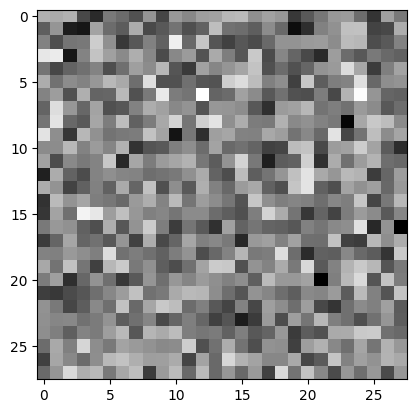

In [23]:
generator= build_generator()

noise = tf.random.normal([1,100])
generated_image = generator(noise, training= False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

In [30]:
def train(generator=None, discriminator= None, gal_model= None, epochs=1000, batch_size=128, z_dim=100, sample_interval=200):
    (X_train, _), (_, _) = datasets.fashion_mnist.load_data()
    X_train = X_train /127.5 - 1

    real_y= np.ones((batch_size))
    fake_y= np.zeros((batch_size))

    for i in range(epochs):
        id = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs= X_train[id]

        noise= np.random.normal(0, 1, (batch_size, z_dim))
        fake_imgs = generator.predict(noise)

        disc_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        disc_loss_fake = discriminator.train_on_batch(real_imgs, fake_y)

        discriminator_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)
        noise= np.random.normal(0,1,(batch_size, z_dim))
        gen_loss = gan_model.train_on_batch(noise, real_y)

        print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epochs, discriminator_loss[0], 100*discriminator_loss[1], gen_loss))
        if epochs % sample_interval == 0:
            sample_images(epochs,generator)


In [31]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

In [32]:
generator=build_generator()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 512)               0         
                                                                 
 batch_normalization_19 (Bat  (None, 512)              2048      
 chNormalization)                                    

In [33]:
# Noise for generator
z_dim = 100
z = Input(shape=(z_dim,))
img = generator(z)

# Fix the discriminator
discriminator.trainable = False

# Get discriminator output
validity = discriminator(img)

# Stack discriminator on top of generator
gan_model = Model(z, validity)
gan_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))
gan_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 100)]             0         
                                                                 
 sequential_10 (Sequential)  (None, 28, 28, 1)         1493520   
                                                                 
 sequential_9 (Sequential)   (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [49]:
def sample_images(epoch, generator, z_dim=100,
                  save_output=True,
                  output_dir="D:\Projects\Completed\ML Project\ClothsGenerator\output_dir"):


    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, z_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # get output shape
    output_shape = len(generator.output_shape)

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            if output_shape == 3:
                axs[i, j].imshow(gen_imgs[cnt, :, :], cmap='gray')
            else:
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            # if model_type == 'cgan':
            #     axs[i, j].set_title("Label: %d" % sampled_labels[cnt])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    if save_output:
        fig.savefig("{}/{}.png".format(output_dir, epoch))
    plt.close()

In [ ]:
train(generator,discriminator,gan_model,epochs=30000, batch_size=32, sample_interval=200)